# Energy Reconstruction Using CNN

## General Notes:
This notebook is designed for regression convolutional neural networks used to reconstruct the energy of a cosmic ray primary. It assumes all input is normalized as a best-practice.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import math
import glob
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import data_tools as dt
simPrefix = os.getcwd()+'\\simdata'

## Assessment Data

In [2]:
# Load data, x in four layers (q1, q2, t1, t2) and y as a dictionary with event-level parameters
#x, y = dt.load_preprocessed('simFiles', 'assessment', comp=['p','h','o','f'])
x, y = dt.load_preprocessed(simPrefix, 'assessment')

Percentage of events with a NaN: 2.68


In [3]:
print(x.shape)

(61016, 10, 10, 4)


In [4]:
print(y.keys())
print('Compositions present: ', sorted(list(set(y['comp']))))

dict_keys(['comp', 'energy', 'dir', 'plane_dir', 'laputop_dir', 'small_dir'])
Compositions present:  [1, 56]


In [5]:
# Event-level parameters
# True values
theta, phi = y['dir'].transpose()
theta = np.pi - theta  # Define 0 degrees as overhead

## Notes

This notebook is designed to compare multiple models for beginners in machine learning

## Model Loading

In [6]:
# Load models
models = {}
recoE = {}
p = {}

In [7]:
# List of available models (CLEAN UP)
modelList = sorted(glob.glob('models/*.h5'))
modelList = [os.path.basename(m)[:-3] for m in modelList]

paramList = sorted(glob.glob('models/*.npy'))
paramList = [os.path.basename(p)[:-4] for p in paramList]

print('Available models:', sorted(set(modelList).intersection(paramList)))
print('\nModels without parameter files:', sorted(set(modelList).difference(paramList)))

Available models: ['model_q1q2Comp0', 'model_q1q2Comp1', 'model_q1q2Comp2', 'model_q1q2cosZ1', 'model_q1q2cosZ2', 'model_q1q2cosZ3', 'model_q1q2cosZ4', 'model_q1q2cosZComp0']

Models without parameter files: ['model_first_model', 'model_q1q2Comp3', 'model_q1q2Z', 'model_q1q2cosZ', 'model_q1q2cosZ0', 'model_q1q2cosZ1000', 'model_q1q2cosZComp1']


In [8]:
# Keys you want to study
#keyList = ['B_plane_None','model_q1q2Comp0','model_q1q2Comp1','model_q1q2Comp2','functionalcosZ4','largemodel_Best_w_zenith','smallmodel_Best_w_zenith']
#keyList = ['B_plane_None','model_q1q2Comp0','model_q1q2Comp1','model_q1q2Comp2']
#labels = {'B_plane_None':'Brandon','model_q1q2Comp0':'Peter_0','model_q1q2Comp1':'Peter_1','model_q1q2Comp2':'Peter_2','functionalcosZ4':'Kennedy','largemodel_Best_w_zenith':'Caden_L','smallmodel_Best_w_zenith':'Caden_S'}
#labels = {'B_plane_None':'Brandon','model_q1q2Comp0':'Peter_0','model_q1q2Comp1':'Peter_1','model_q1q2Comp2':'Peter_2'}

keyList = ['model_q1q2cosZ3']
labels = {'model_q1q2cosZ3':'Peter'}


# Automatic intake of parameters from parameter files
p = {}
for key in keyList:
    d = np.load(f'models/{key}.npy', allow_pickle=True)
    p[key] = d.item()

# Manually input parameters
#p = {'B_plane_None':{'q':None, 't':False, 'normed':True}
#    }

In [9]:
# Calculate reconstructed energies. This can take a bit, but should print out info on each key as it works
for key in keyList:

    # Comment these two lines if you want to rerun your energy reconstructions each time
    #if key in models.keys():
    #    continue

    print('Working on {}...'.format(key))
    # Note: very sensitive to tensorflow/keras version.
    models[key] = load_model('models/%s.h5' % key)
    
    # Configure input data
    x_i = dt.dataPrep(x, y, **p[key])
    comp = y['comp']
    energy = y['energy']
    
    
    print('Model parameters')
    print(p[key])
    
    # Models should only output energy
    recoE[key] = models[key].predict([x_i[0],x_i[1]]).flatten()

Working on model_q1q2cosZ3...
Model parameters
{'q': None, 't': False, 'normed': True, 'reco': 'plane', 'cosz': True}


In [10]:
len(recoE['model_q1q2cosZ3'])

61016

## Plotting Parameters

In [11]:
def getCut(cut_str, x, y, key):
    if cut_str == 'No Cut':
        cut = np.array([True for i in x])
    if cut_str == 'Quality Cut':
        cut = dt.qualityCut(x, y)
    cut *= ~np.isnan(recoE[key])
    return cut

In [12]:
ebins = np.linspace(5, 8, 181)
evalues = (ebins[:-1] + ebins[1:]) / 2

In [13]:
cutNames = ['No Cut', 'Quality Cut']
ncols = len(cutNames)   # one column for each cut
nrows = len(keyList)    # one row for each model

## Energy Reconstruction Plots

### Total Energy Resolution

In [14]:
# Option to change font size for all labels within this notebook
labelParams = {'fontsize':16}

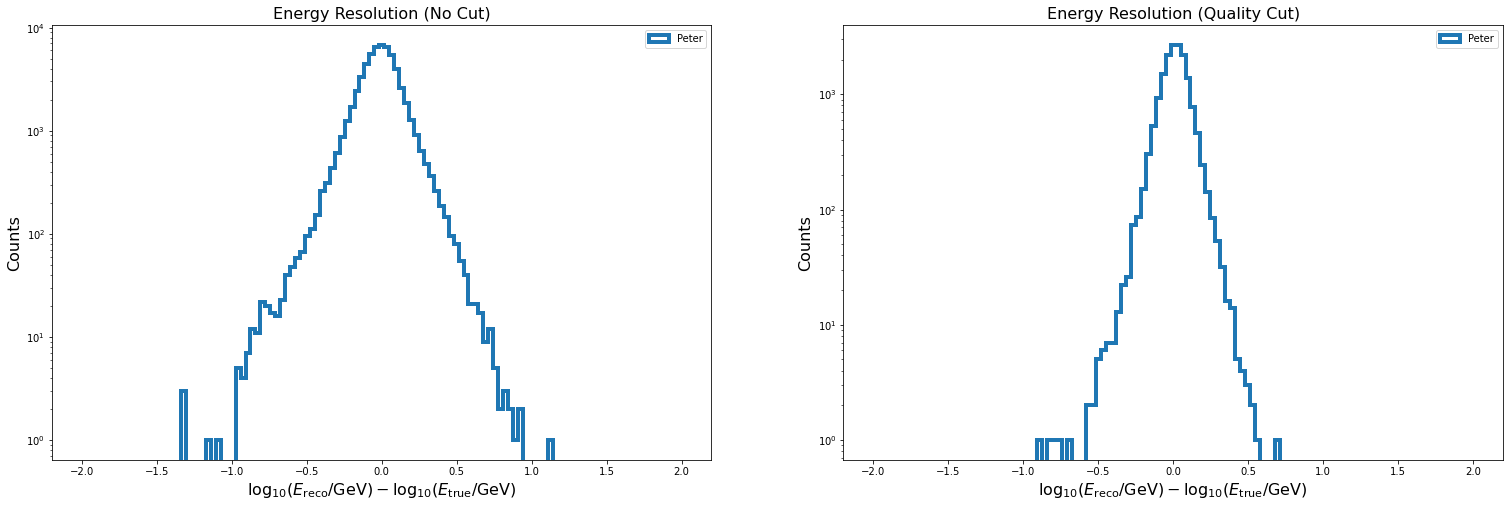

In [15]:
histArgs = {'range':(-2,2), 'bins':121, 'histtype':'step', 'log':True, 'linewidth':4}
fig, axs = plt.subplots(figsize=(13*ncols, 8), ncols=ncols)

for i, cutName in enumerate(cutNames):
    ax = axs[i]
    for j, key in enumerate(keyList):
        cut = getCut(cutName, x, y, key)
        ax.hist((recoE[key][cut] - energy[cut]), label=labels[key], **histArgs)
        ax.set_xlabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **labelParams)
        ax.set_ylabel('Counts', **labelParams)
    ax.set_title('Energy Resolution (%s)' % cutName, **labelParams)
    ax.legend()

plt.show()

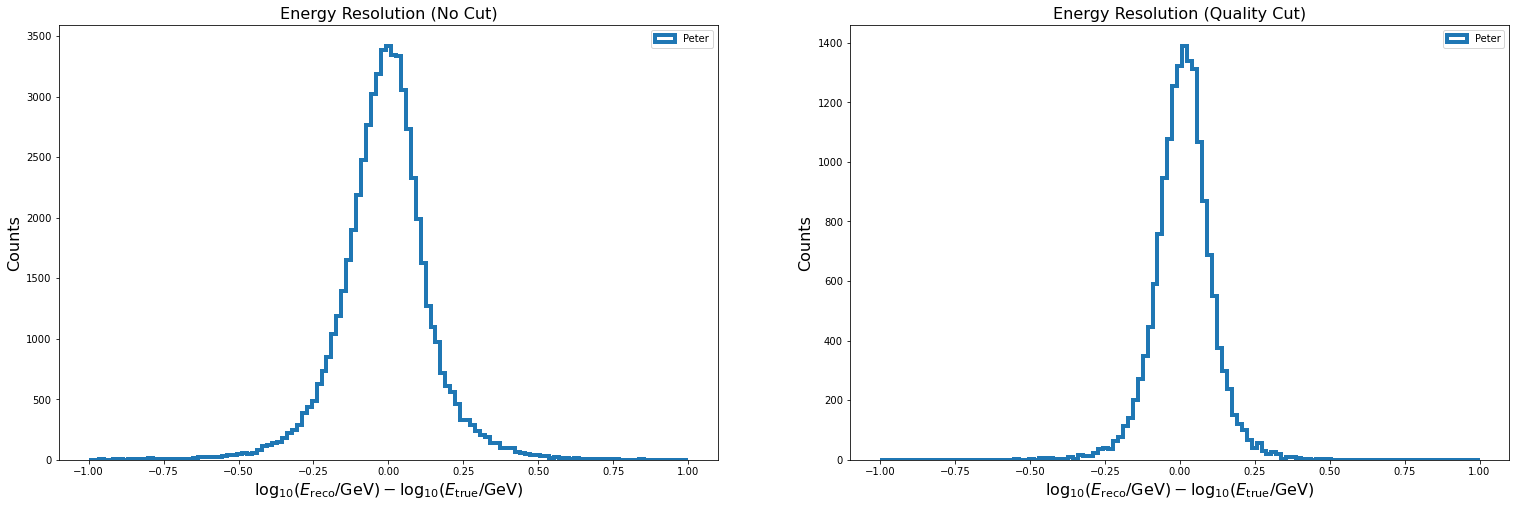

In [16]:
# Goal: plot energy resolution
histArgs = {'range':(-1,1), 'bins':121, 'histtype':'step', 'linewidth':4}
fig, axs = plt.subplots(figsize=(13*ncols, 8), ncols=ncols)

for i, cutName in enumerate(cutNames):
    ax = axs[i]
    for j, key in enumerate(keyList):
        cut = getCut(cutName, x, y, key)
        ax.hist((recoE[key][cut] - energy[cut]), label=labels[key], **histArgs)
    ax.set_title('Energy Resolution (%s)' % cutName, **labelParams)
    ax.set_xlabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **labelParams)
    ax.set_ylabel('Counts', **labelParams)
    ax.legend()

plt.show()

In [17]:
# Summary parameters
for key in keyList:
    for i, cutName in enumerate(cutNames):
        cut = getCut(cutName, x, y, key)
        median, err_min, err_max = np.percentile(recoE[key][cut] - energy[cut], (50,16,84))
        print('Energy resolution for %s (%s): %.03f +%.03f %.03f' % (key, cutName, median, err_max, err_min))
    print()

Energy resolution for model_q1q2cosZ3 (No Cut): -0.008 +0.110 -0.137
Energy resolution for model_q1q2cosZ3 (Quality Cut): 0.014 +0.094 -0.069



### Two-Dimensional Visualization

Note: standardize colorbars across plots!

C:\Users\peter\anaconda3\envs\hello-tf\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
C:\Users\peter\anaconda3\envs\hello-tf\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


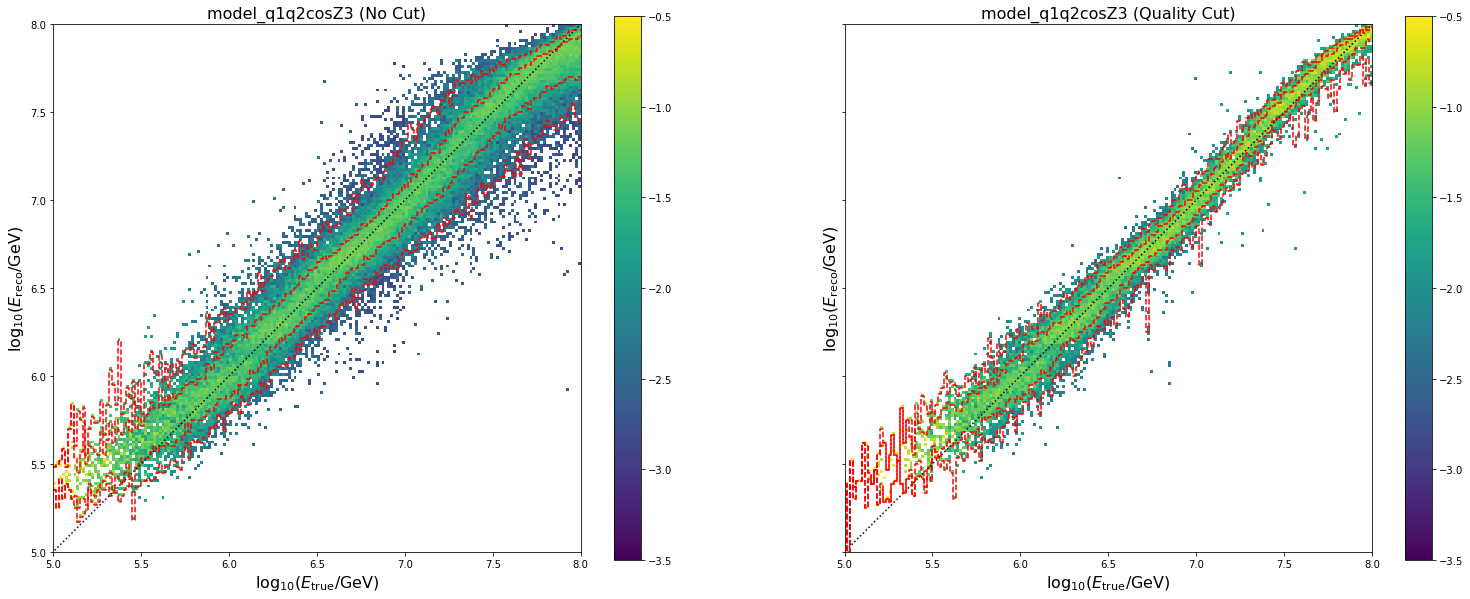

In [18]:
fig, axs = plt.subplots(figsize=(13*ncols, 10*nrows), ncols=ncols, nrows=nrows, 
                        sharex=True, sharey=True)

for i, key in enumerate(keyList):
    for j, cutName in enumerate(cutNames):
        
        ax = axs[i, j] if len(keyList) > 1 else axs[j]
        cut = getCut(cutName, x, y, key)
        
        h, xedges, yedges = np.histogram2d(recoE[key][cut], energy[cut], bins=(ebins, ebins), 
                                           normed=False, weights=None)
        # Normalize
        ntot = np.sum(h, axis=0).astype(float)
        ntot[ntot==0] = 1.
        h /= ntot
        
        # Create contours
        contourValues = [0.025, 0.16, 0.84, 0.975]
        contourList = [[] for i in contourValues]
        for c, col in enumerate(h.transpose()):
            ccol = col.cumsum()
            for l, val in zip(contourList, contourValues):
                try: l += [np.where(ccol > val)[0][0]]
                except IndexError:
                    l += [0]
        for l in contourList:
            l.insert(0, l[0])
            if i >= len(contourList) / 2:
                l = [j+1 for j in l]     
        ax.plot(evalues, evalues, 'k', ls=':')
        for l in contourList:
            ax.step(ebins, ebins[l], color='red', linestyle='--')
        
        # Plot on a log scale
        extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
        im = ax.imshow(np.log10(h), extent=extent, origin='lower', interpolation='none', vmin=-3.5, vmax=-0.5)
        ax.set_title('%s (%s)' % (key, cutName), **labelParams)
        ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **labelParams)
        ax.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', **labelParams)
        fig.colorbar(im, ax=ax)
    
plt.show()

### Energy resolution as a function of true energy

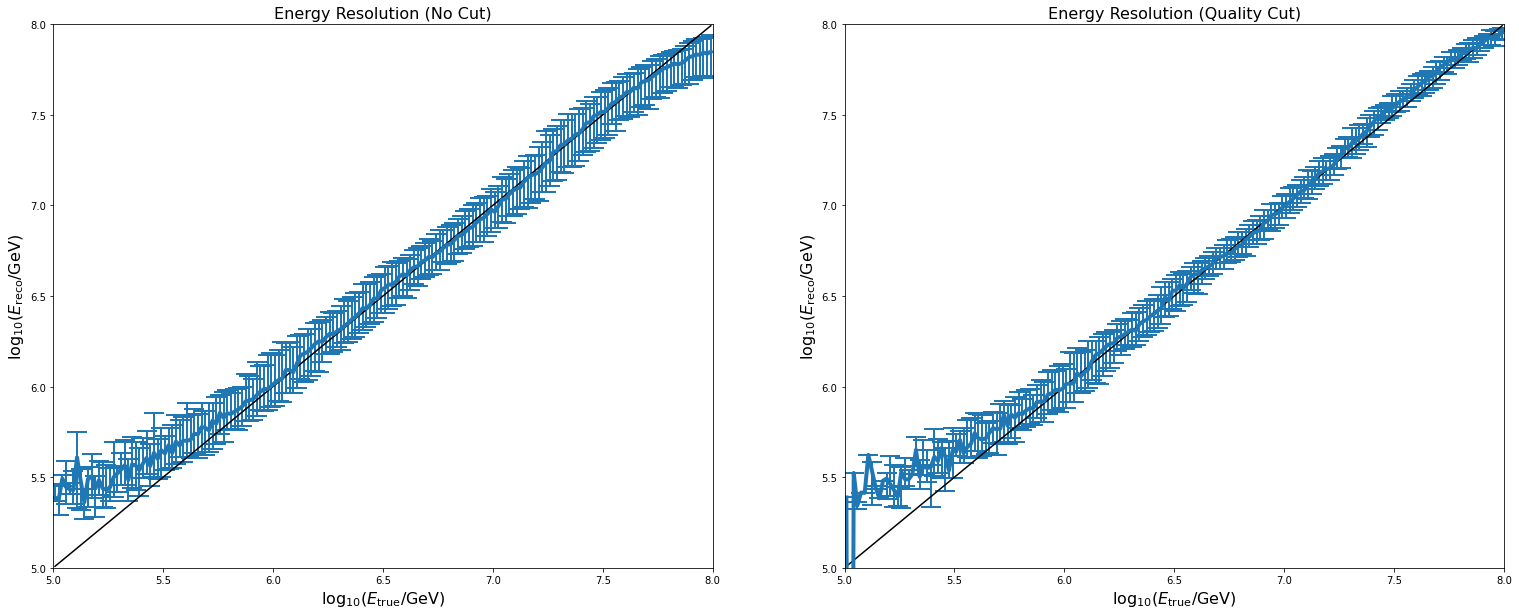

In [19]:
kwargs = {'fmt':'-',
          'linewidth':4,
          'markersize':16,
          'elinewidth':2,
          'capsize':10,
          'capthick':2}

fig, axs = plt.subplots(figsize=(13*ncols, 10), ncols=ncols)

for i, cutName in enumerate(cutNames):
    ax = axs[i]
    for k, key in enumerate(keyList):
        array_info = np.zeros(shape=(len(evalues), 3))
        cut = getCut(cutName, x, y, key)
        binned_energy = np.digitize(energy[cut], ebins) - 1
        for j in range(len(evalues)):
            ecut = (binned_energy == j)
            temp_events = recoE[key][cut][ecut]
            if len(temp_events) != 0:
                array_info[j] = np.percentile(temp_events, (50, 16, 84))

        ave, err_min, err_max = np.transpose(array_info)
        ax.errorbar(evalues, ave, yerr=(ave-err_min, err_max-ave), label=key, **kwargs)
    
    ax.set_title('Energy Resolution (%s)' % cutName, **labelParams)
    ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$',**labelParams)
    ax.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$',**labelParams)
    ax.set_xlim(5,8)
    ax.set_ylim(5,8)
    ax.plot(evalues, evalues, color='k')
    #ax.legend()

plt.show()

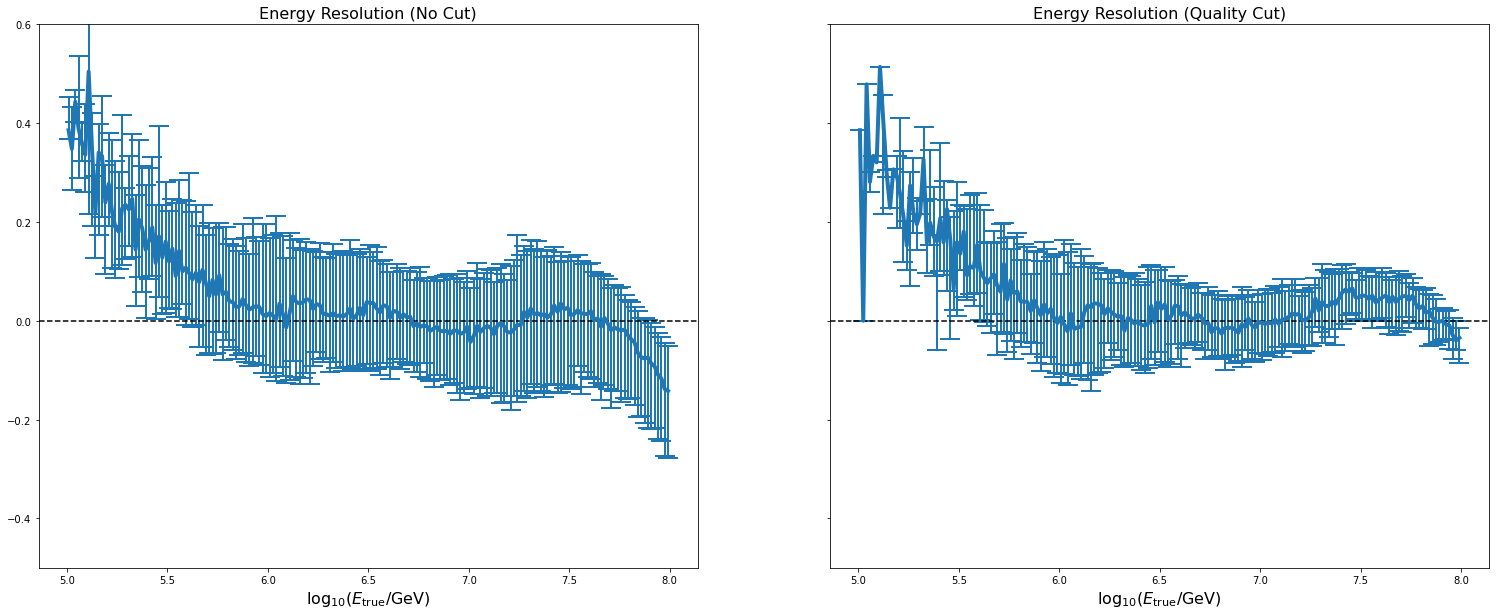

In [20]:
kwargs = {'fmt':'-',
          'linewidth':4,
          'markersize':16,
          'elinewidth':2,
          'capsize':10,
          'capthick':2}

fig, axs = plt.subplots(figsize=(13*ncols, 10), ncols=ncols, sharey=True)

for i, cutName in enumerate(cutNames):
    ax = axs[i]
    for k, key in enumerate(keyList):
        array_info = np.zeros(shape=(len(evalues), 3))
        cut = getCut(cutName, x, y, key)
        binned_energy = np.digitize(energy[cut], ebins) - 1
        for j in range(len(evalues)):
            ecut = (binned_energy == j)
            temp_events = recoE[key][cut][ecut]
            if len(temp_events) != 0:
                array_info[j] = np.percentile(temp_events - energy[cut][ecut], (50, 16, 84))

        ave, err_min, err_max = np.transpose(array_info)
        ax.errorbar(evalues, ave, yerr=(ave-err_min, err_max-ave), label=key, **kwargs)
        # If you want to use shaded error bars...
        #ax.fill_between(evalues[key], err_min, err_max, alpha=0.2)
    
    ax.set_title('Energy Resolution (%s)' % cutName, **labelParams)
    ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **labelParams)
    #ax.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **labelParams)
    ax.set_ylim(-0.5, 0.6)
    ax.axhline(color='k', ls='--')
    #ax.legend()

plt.show()

### Energy resolution as a function of zenith

In [21]:
coszbins = np.linspace(0.4,1,20)
coszvalues = (coszbins[1:]+coszbins[:-1])/2

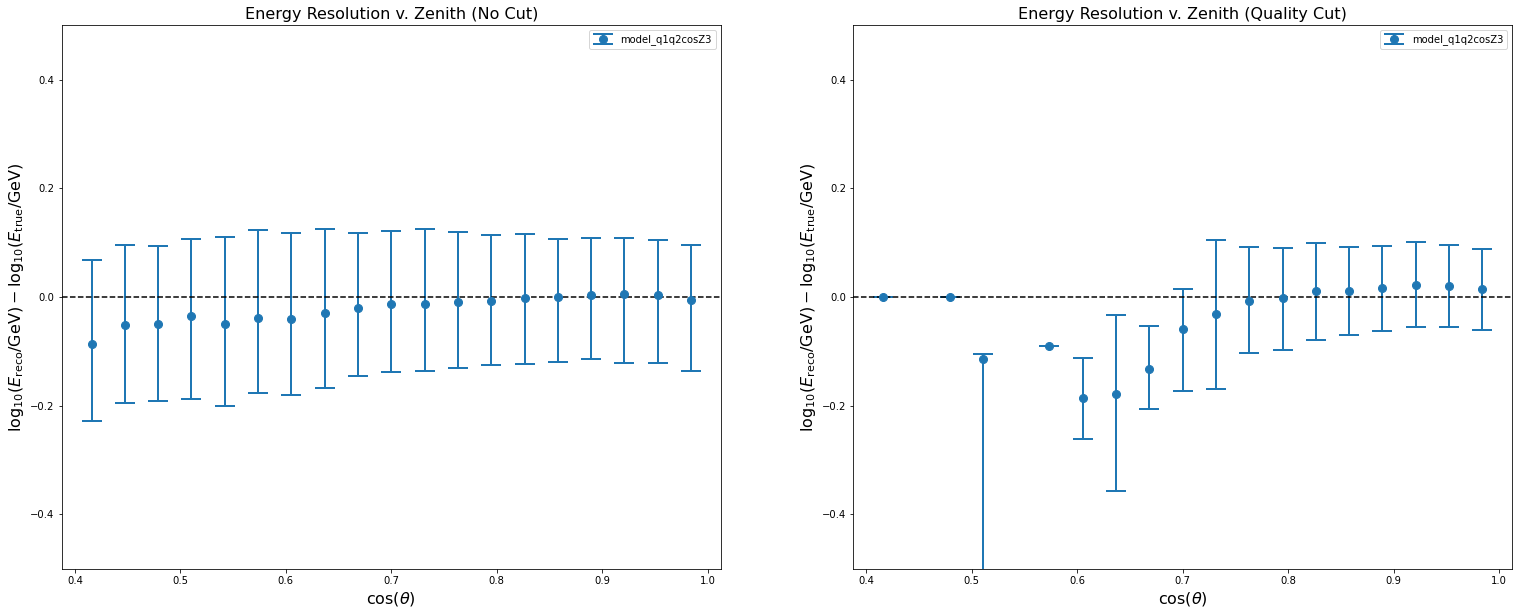

In [22]:
kwargs = {'fmt':'.',
          'markersize':16,
          'elinewidth':2,
          'capsize':10,
          'capthick':2}
fig, axs = plt.subplots(figsize=(13*ncols, 10), ncols=ncols)

for i, cutName in enumerate(cutNames):
    ax = axs[i]
    for k, key in enumerate(keyList):
        array_info = np.zeros(shape=(len(coszvalues), 3))
        cut = getCut(cutName, x, y, key)
        binned_zenith = np.digitize(np.cos(theta)[cut], coszbins) - 1
        for j in range(len(coszvalues)):
            coszcut = (binned_zenith == j)
            temp_events = recoE[key][cut][coszcut]
            if len(temp_events) != 0:
                array_info[j] = np.percentile(temp_events - energy[cut][coszcut], (50, 16, 84))

        median, err_min, err_max = np.transpose(array_info)
        ax.errorbar(coszvalues, median, yerr=(median-err_min, err_max-median), label=key, **kwargs)
    
    ax.axhline(color='k', ls='--')
    ax.set_title('Energy Resolution v. Zenith (%s)' % cutName, **labelParams)
    ax.set_xlabel(r'$\cos(\theta)$', **labelParams)
    ax.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **labelParams)
    ax.set_ylim(-0.5, 0.5)
    ax.legend()
    
plt.show()

## Composition studies

In [23]:
pCut = (comp==0)
fCut = (comp==1)
pArgs = {'label':'P', 'color':'blue'}
fArgs = {'label':'Fe', 'color':'red'}
compArgs = [pArgs, fArgs]

In [24]:
ebins = np.linspace(5, 8, 61)
evalues = (ebins[:-1] + ebins[1:]) / 2

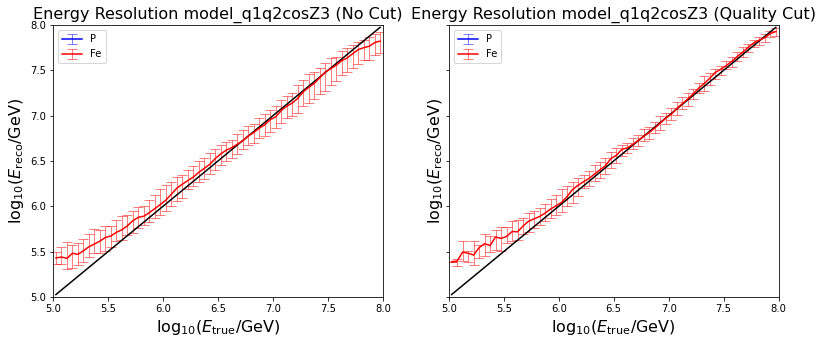

In [25]:
kwargs = {'fmt':'-',
          'elinewidth':0.5,
          'capsize':5,
          'capthick':0.5}
fig, axs = plt.subplots(figsize=(6.5*ncols, 5*nrows), ncols=ncols, nrows=nrows,
                       sharex=True, sharey=True)

for i, key in enumerate(keyList):
    for j, cutName in enumerate(cutNames):
        ax = axs[i, j] if len(keyList) > 1 else axs[j]
        cut = getCut(cutName, x, y, key)
        for c, comp in enumerate([pCut, fCut]):
            array_info = np.zeros(shape=(len(evalues), 3))
            binned_energy = np.digitize(energy[cut], ebins) - 1
            for k in range(len(evalues)):
                ecut = (binned_energy == k) * comp[cut]
                temp_events = recoE[key][cut][ecut]
                if len(temp_events) != 0:
                    array_info[k] = np.percentile(temp_events, (50, 16, 84))

            ave, err_min, err_max = np.transpose(array_info)
            ax.errorbar(evalues, ave, yerr=(ave-err_min, err_max-ave), **kwargs, **compArgs[c])
    
        ax.set_title('Energy Resolution %s (%s)' % (key, cutName), **labelParams)
        ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **labelParams)
        ax.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', **labelParams)
        ax.set_xlim(5,8)
        ax.set_ylim(5,8)
        ax.plot(evalues, evalues, color='k')
        ax.legend()

plt.show()

## Recreating 3-year Plots

In [26]:
from scipy.optimize import curve_fit
def gaus(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [27]:
ebins = np.linspace(5, 8, 31)
evalues = (ebins[:-1] + ebins[1:]) / 2

In [28]:
key = 'B_plane_None'
e_diff = recoE[key] - energy
binned_energy = np.digitize(recoE[key], ebins) - 1
bins = np.linspace(-1, 1, 50)
mids = (bins[1:]+bins[:-1])/2

for i in range(len(evalues)):
    cut = (binned_energy == i)
    e_dist, _ = np.histogram(e_diff[cut], bins=bins)
    if e_dist.sum() == 0:
        continue
    e_dist = e_dist/e_dist.sum()
    popt, pcov = curve_fit(gaus, mids, e_dist, p0=[1, e_dist.mean(), np.sqrt(e_dist.var())])
    
    fig, ax = plt.subplots()
    ax.hist(e_diff[cut], bins=bins, weights=np.ones(len(e_diff[cut]))/len(e_diff[cut]), density=False)
    ax.plot(mids, gaus(mids, *popt))
    plt.show()

KeyError: 'B_plane_None'

In [ ]:
kwargs = {'marker':'.',
          'linestyle':''}
fig, axs = plt.subplots(figsize=(6.5*ncols, 5*nrows), ncols=ncols, nrows=nrows*2,
                       sharex=True)

for i, key in enumerate(keyList):

    for j, cutName in enumerate(cutNames):

        cut = getCut(cutName, x, y, key)
        e_mean = np.zeros(shape=(len(evalues)))
        sigma = np.zeros(shape=(len(evalues)))
        binned_energy = np.digitize(recoE[key][cut], ebins) - 1

        for k in range(len(evalues)):

            ecut = (binned_energy == k)
            e_diff = recoE[key][cut][ecut] - energy[cut][ecut]
            e_mean[k] = np.mean(e_diff)
            sigma[k] = np.sqrt(np.var(e_diff))

            # Kath's approach: fit a Gaussian to each distribution to extract mean and stdev
            e_dist, _ = np.histogram(e_diff, bins=bins)
            if e_dist.sum() == 0:
                continue
            e_dist = e_dist/e_dist.sum()
            popt, pcov = curve_fit(gaus, mids, e_dist, p0=[1, e_dist.mean(), np.sqrt(e_dist.var())])
            #amp, e_mean[k], sigma[k] = popt
            
        ax = axs[i, j]
        ax.step(evalues, e_mean, where='mid', **kwargs)
        ax.set_title('Energy Resolution %s (%s)' % (key, cutName))
        ax.set_ylabel(r'$\left\langle\log_{10}(E_{\mathrm{reco}}) - \log_{10}(E_{\mathrm{true}})\right\rangle$')
        ax.set_ylim(-.1, .15)
        
        ax = axs[i+1, j]
        ax.step(evalues, sigma, where='mid', **kwargs)
        ax.set_ylabel(r'$\sigma$')
        ax.set_ylim(0, 0.2)
        
        #for c, comp in enumerate([pCut, fCut]):
        #    array_info = np.zeros(shape=(len(evalues), 3))
        #    binned_energy = np.digitize(energy[cut], ebins) - 1
        #    for k in range(len(evalues)):
        #        ecut = (binned_energy == k) * comp[cut]
        #        temp_events = recoE[key][cut][ecut]
        #        if len(temp_events) != 0:
        #            array_info[k] = np.percentile(temp_events, (50, 16, 84))

         #   ave, err_min, err_max = np.transpose(array_info)
         #   ax.errorbar(evalues, ave, yerr=(ave-err_min, err_max-ave), **kwargs, **compArgs[c])


        ax.set_xlabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
        ax.set_xlim(5,8)

        #ax.legend()

plt.subplots_adjust(hspace=0)
        
plt.show()